In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import acf
import datetime

from numpy import inf

from IPython.display import display, HTML
display(HTML(""" <style> .output {display: center; align-items: left; text-align: center; justify-content: center; } </style> """))

In [2]:
#Importación de datos
datos = pd.read_excel('Generación Intermitente de la GCROC 2013-2020.xlsx', header=1)

In [3]:
numbers = datos.hora-1
hours = [datetime.time(num).strftime("%H:00:00") for num in numbers]
datos['fecha'] = datos['fecha'].replace(0,np.nan).ffill()
datos['fecha'] = pd.to_datetime(datos['fecha'])
datos['fecha'] = datos['fecha'].dt.date
datos['fecha_hora'] = datos["fecha"].astype(str) + ' ' + hours
datos.head()

,dia de la semana,fecha,hora,GICIE301,GICIE302,GICIE303,GICIE304,GICIE305,GICIS306,GICIS307,...,GICIS318,GICIS319,GICIS320,GICIS321,GICIS322,GICIS323,GICIS324,GICIS325,GICIS326,fecha_hora
NaN,Jueves,2013-11-14,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 00:00:00
NaN,NaN,2013-11-14,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 01:00:00
NaN,NaN,2013-11-14,3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 02:00:00
NaN,NaN,2013-11-14,4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 03:00:00
NaN,NaN,2013-11-14,5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 04:00:00


In [4]:
datos.tail()

,dia de la semana,fecha,hora,GICIE301,GICIE302,GICIE303,GICIE304,GICIE305,GICIS306,GICIS307,...,GICIS318,GICIS319,GICIS320,GICIS321,GICIS322,GICIS323,GICIS324,GICIS325,GICIS326,fecha_hora
NaN,NaN,2020-03-09,20,12140.0,6879.0,26607.0,19358.0,10983.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 19:00:00
NaN,NaN,2020-03-09,21,4313.0,31473.0,14942.0,3029.0,15129.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 20:00:00
NaN,NaN,2020-03-09,22,98.0,54796.0,33875.0,22778.0,8490.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 21:00:00
NaN,NaN,2020-03-09,23,803.0,57081.0,34073.0,36240.0,16482.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 22:00:00
NaN,NaN,2020-03-09,24,7594.0,56351.0,39697.0,45519.0,22479.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 23:00:00


In [5]:
#LIMPIEZA DE DATOS
datos = datos.set_index(datos['fecha_hora'])
datos = datos[53736:]

In [6]:
n_periods = 5*24

In [7]:
columns = ['GICIE301', 'GICIE302','GICIE303','GICIE304','GICIE305','GICIS306', 'GICIS307','GICIS308',
          'GICIS309','GICIS310','GICIS311','GICIS312','GICIS313','GICIS314','GICIS315','GICIS316','GICIS317',
          'GICIS318','GICIS319','GICIS320','GICIS321','GICIS322','GICIS323','GICIS324','GICIS325','GICIS326']

In [8]:
columna = columns[14]
columna

'GICIS315'

In [9]:
def mape(forecast, actual):
    return np.mean(np.abs((forecast - actual)/actual))  # MAPE

In [10]:
def AIC_accuracy(train,test):
    fcc = []
    for i in range(1,25):
        
        data = train['Hora '+str(i)].dropna()
        model = pm.auto_arima(data.values, start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=5, max_q=5, # maximum p and q
                          m=12,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=True,   # No Seasonality
                          start_P=0, 
                          D=0, 
                          trace=False,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
        #model.fit(data.values)
        #print(model)
        #model.plot_diagnostics(figsize=(7,5))
        #plt.show()
        # Predicción
        fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
        fcc.append(fc)
    return(fcc, model)

In [11]:
data2 = datos[['hora',columna]]
data2[columna] = (data2[columna]) # para efectos de las tranformaciones logaritmicas(eliminar el 0)
#data2 = data2.dropna()
data2

,hora,GICIS315
fecha_hora,,
2020-01-01 00:00:00,1,0.0
2020-01-01 01:00:00,2,0.0
2020-01-01 02:00:00,3,0.0
2020-01-01 03:00:00,4,0.0
2020-01-01 04:00:00,5,0.0
2020-01-01 05:00:00,6,0.0
2020-01-01 06:00:00,7,0.0
2020-01-01 07:00:00,8,0.0
2020-01-01 08:00:00,9,0.0


In [12]:
#Se separará por hora del día, ya que cada hora se comporta diferente.
xhr = pd.DataFrame() ; log = pd.DataFrame() ; rends = pd.DataFrame() ; rlogs = pd.DataFrame()
ano,dia,hora= str(data2.index[1])[0:4], str(data2.index[1])[5:7] ,str(data2.index[1])[8:10]

In [13]:
#El siguiente ciclo 'for' crea un DataFrame acomodado por horas, de cada planta de generación.
for i in range(1,25):
    hrs = [data2.iloc[j][1] for j in range(len(data2)) if data2.iloc[j][0] == i ] #pd.Series()
    xhr['Hora '+str(i)] = hrs
xhr

,Hora 1,Hora 2,Hora 3,Hora 4,Hora 5,Hora 6,Hora 7,Hora 8,Hora 9,Hora 10,...,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19,Hora 20,Hora 21,Hora 22,Hora 23,Hora 24
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,50709.000000,33766.000000,18835.000000,3948.000000,0.00000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,384.000000,10345.000000,65380.00000,...,75485.000000,73713.000000,66819.000000,9898.000000,310.00000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,246.000000,34093.000000,94931.00000,...,94633.000000,96494.000000,89432.000000,31086.000000,78.00000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2479.000000,37740.000000,81554.00000,...,99012.000000,99983.000000,90848.000000,33681.000000,98.00000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1355.000000,38871.000000,95893.00000,...,94476.000000,97566.000000,88617.000000,33087.000000,112.00000,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1141.000000,36594.000000,88746.00000,...,91241.000000,90775.000000,79570.000000,29421.000000,393.00000,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1901.000000,9824.000000,16226.00000,...,64752.000000,84746.000000,72143.000000,23802.000000,153.00000,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1237.000000,31393.000000,82165.00000,...,69222.000000,39494.000000,63415.000000,11467.000000,80.00000,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,889.000000,31431.000000,83796.00000,...,55939.000000,44688.000000,30671.000000,29050.000000,580.00000,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,806.000000,29206.000000,82130.00000,...,79665.000000,89094.000000,77138.000000,29476.000000,339.00000,0.0,0.0,0.0,0.0,0.0


In [14]:
#Se va a trabajar con logaritmicos, porque esta transformación no afecta el vlaor, sino solo su rango.
#log = np.log(xhr+1)
log = xhr
log

,Hora 1,Hora 2,Hora 3,Hora 4,Hora 5,Hora 6,Hora 7,Hora 8,Hora 9,Hora 10,...,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19,Hora 20,Hora 21,Hora 22,Hora 23,Hora 24
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,50709.000000,33766.000000,18835.000000,3948.000000,0.00000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,384.000000,10345.000000,65380.00000,...,75485.000000,73713.000000,66819.000000,9898.000000,310.00000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,246.000000,34093.000000,94931.00000,...,94633.000000,96494.000000,89432.000000,31086.000000,78.00000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2479.000000,37740.000000,81554.00000,...,99012.000000,99983.000000,90848.000000,33681.000000,98.00000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1355.000000,38871.000000,95893.00000,...,94476.000000,97566.000000,88617.000000,33087.000000,112.00000,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1141.000000,36594.000000,88746.00000,...,91241.000000,90775.000000,79570.000000,29421.000000,393.00000,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1901.000000,9824.000000,16226.00000,...,64752.000000,84746.000000,72143.000000,23802.000000,153.00000,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1237.000000,31393.000000,82165.00000,...,69222.000000,39494.000000,63415.000000,11467.000000,80.00000,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,889.000000,31431.000000,83796.00000,...,55939.000000,44688.000000,30671.000000,29050.000000,580.00000,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,806.000000,29206.000000,82130.00000,...,79665.000000,89094.000000,77138.000000,29476.000000,339.00000,0.0,0.0,0.0,0.0,0.0


In [15]:
#Se le cambia el index a los DataFrame creados, por las fechas que son.
xhr = xhr.set_index(pd.date_range(start=datos['fecha'][0],end=datos['fecha'][-1],freq='d'))
xhr

,Hora 1,Hora 2,Hora 3,Hora 4,Hora 5,Hora 6,Hora 7,Hora 8,Hora 9,Hora 10,...,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19,Hora 20,Hora 21,Hora 22,Hora 23,Hora 24
2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,50709.000000,33766.000000,18835.000000,3948.000000,0.00000,0.0,0.0,0.0,0.0,0.0
2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,384.000000,10345.000000,65380.00000,...,75485.000000,73713.000000,66819.000000,9898.000000,310.00000,0.0,0.0,0.0,0.0,0.0
2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,246.000000,34093.000000,94931.00000,...,94633.000000,96494.000000,89432.000000,31086.000000,78.00000,0.0,0.0,0.0,0.0,0.0
2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2479.000000,37740.000000,81554.00000,...,99012.000000,99983.000000,90848.000000,33681.000000,98.00000,0.0,0.0,0.0,0.0,0.0
2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1355.000000,38871.000000,95893.00000,...,94476.000000,97566.000000,88617.000000,33087.000000,112.00000,0.0,0.0,0.0,0.0,0.0
2020-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1141.000000,36594.000000,88746.00000,...,91241.000000,90775.000000,79570.000000,29421.000000,393.00000,0.0,0.0,0.0,0.0,0.0
2020-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1901.000000,9824.000000,16226.00000,...,64752.000000,84746.000000,72143.000000,23802.000000,153.00000,0.0,0.0,0.0,0.0,0.0
2020-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1237.000000,31393.000000,82165.00000,...,69222.000000,39494.000000,63415.000000,11467.000000,80.00000,0.0,0.0,0.0,0.0,0.0
2020-01-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,889.000000,31431.000000,83796.00000,...,55939.000000,44688.000000,30671.000000,29050.000000,580.00000,0.0,0.0,0.0,0.0,0.0
2020-01-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,806.000000,29206.000000,82130.00000,...,79665.000000,89094.000000,77138.000000,29476.000000,339.00000,0.0,0.0,0.0,0.0,0.0


In [16]:
#Seleccion de y_train y y_test
test = (xhr.iloc[-5:,:])   # INFO DE TEST
train = log.drop(log.index[1945:]) # QUITANDO TEST PARA TRAIN

In [17]:
train,test

(    Hora 1  Hora 2  Hora 3  Hora 4  Hora 5  Hora 6  Hora 7       Hora 8  \
 0      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.000000   
 1      0.0     0.0     0.0     0.0     0.0     0.0     0.0   384.000000   
 2      0.0     0.0     0.0     0.0     0.0     0.0     0.0   246.000000   
 3      0.0     0.0     0.0     0.0     0.0     0.0     0.0  2479.000000   
 4      0.0     0.0     0.0     0.0     0.0     0.0     0.0  1355.000000   
 5      0.0     0.0     0.0     0.0     0.0     0.0     0.0  1141.000000   
 6      0.0     0.0     0.0     0.0     0.0     0.0     0.0  1901.000000   
 7      0.0     0.0     0.0     0.0     0.0     0.0     0.0  1237.000000   
 8      0.0     0.0     0.0     0.0     0.0     0.0     0.0   889.000000   
 9      0.0     0.0     0.0     0.0     0.0     0.0     0.0   806.000000   
 10     0.0     0.0     0.0     0.0     0.0     0.0     0.0   745.000000   
 11     0.0     0.0     0.0     0.0     0.0     0.0     0.0  1325.000000   
 12     0.0 

In [18]:
fcc = []

#MODELO ARIMA
for i in range(1,25):
    y_train = train['Hora '+str(i)].dropna()

    model = pm.auto_arima(y_train.values, start_p=1, start_q=1,
        test='adf',       # use adftest to find optimal 'd'
        max_p=4, max_q=4, # maximum p and q
        m=12,              # frequency of series
        d=None,           # let model determine 'd'
        seasonal=True,    # No Seasonality
        stepwise=True)   

    model.fit(y_train.values)
    #print(model)
    #model.plot_diagnostics(figsize=(7,5))
    #plt.show()

    # Predicción
    fc, confint = model.predict(n_periods=len(test), return_conf_int=True)
    fcc.append(fc)

fc, model = AIC_accuracy(train,test)

In [19]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   69
Model:                        SARIMAX   Log Likelihood                 760.516
Date:                Wed, 25 Mar 2020   AIC                          -1517.031
Time:                        13:48:02   BIC                          -1512.563
Sample:                             0   HQIC                         -1515.259
                                 - 69                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.763e-06   7.36e-14  -5.11e+07      0.000   -3.76e-06   -3.76e-06
sigma2      2.287e-11   2.32e-10      0.099      0.921   -4.32e-10    4.78e-10
===================================================================================
Ljung-Box (Q):                     1996.23   Jarque-Bera (JB):                23.00
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             1.00
Prob(H) (two-sided):                  1.00   Kurtosis:                         1.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.82e+19. Standard errors may be unstable.
"""

In [20]:
fc

[array([-3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.7

In [21]:
fcc

[array([-3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06]),
 array([-3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06]),
 array([-3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06]),
 array([-3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06]),
 array([-3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06]),
 array([-3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06]),
 array([-3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06]),
 array([6758.8366821 , 5799.99588998, 5266.30829359, 5819.14242415,
        5485.21500342]),
 array([53145.46646077, 51886.06189329, 51782.93672926, 52090.16427701,
        52543.02215213]),
 array([68061.51560844, 72130.6596853 , 69622.2723529 , 69596.39818086,
        69179.03

In [22]:
mapes = [mape(fcc[i-1], (test['Hora '+str(i)])) for i in range(1,25)]
mapes = pd.DataFrame(mapes).dropna()
mapes[mapes == inf] = 0
mape_promedio = np.mean(mapes)

In [23]:
dias = []
for j in range(0,5):
    dias.append([([ fc[i][j] for i in range(len(fc))])][0])
pronostico = pd.DataFrame(np.concatenate(dias))
start=datos['fecha'][0]
pronostico = pronostico.set_index(pd.date_range(test.index[0],periods=len(pronostico),freq='H'))
pronostico.index = pronostico.index.map(str)

In [24]:
pronostico

,0
2020-03-05 00:00:00,-0.000004
2020-03-05 01:00:00,-0.000004
2020-03-05 02:00:00,-0.000004
2020-03-05 03:00:00,-0.000004
2020-03-05 04:00:00,-0.000004
2020-03-05 05:00:00,-0.000004
2020-03-05 06:00:00,-0.000004
2020-03-05 07:00:00,6758.836682
2020-03-05 08:00:00,53145.466461
2020-03-05 09:00:00,68061.515608


In [25]:
datos[columna][-1-19*24:]

fecha_hora
2020-02-19 23:00:00        0.0
2020-02-20 00:00:00        0.0
2020-02-20 01:00:00        0.0
2020-02-20 02:00:00        0.0
2020-02-20 03:00:00        0.0
2020-02-20 04:00:00        0.0
2020-02-20 05:00:00        0.0
2020-02-20 06:00:00        0.0
2020-02-20 07:00:00     2700.0
2020-02-20 08:00:00    46334.0
2020-02-20 09:00:00    92741.0
2020-02-20 10:00:00    94824.0
2020-02-20 11:00:00    95058.0
2020-02-20 12:00:00    95007.0
2020-02-20 13:00:00    95458.0
2020-02-20 14:00:00    95688.0
2020-02-20 15:00:00    94174.0
2020-02-20 16:00:00    89240.0
2020-02-20 17:00:00    56165.0
2020-02-20 18:00:00     3674.0
2020-02-20 19:00:00        0.0
2020-02-20 20:00:00        0.0
2020-02-20 21:00:00        0.0
2020-02-20 22:00:00        0.0
2020-02-20 23:00:00        0.0
2020-02-21 00:00:00        0.0
2020-02-21 01:00:00        0.0
2020-02-21 02:00:00        0.0
2020-02-21 03:00:00        0.0
2020-02-21 04:00:00        0.0
                        ...   
2020-03-08 18:00:00     2638

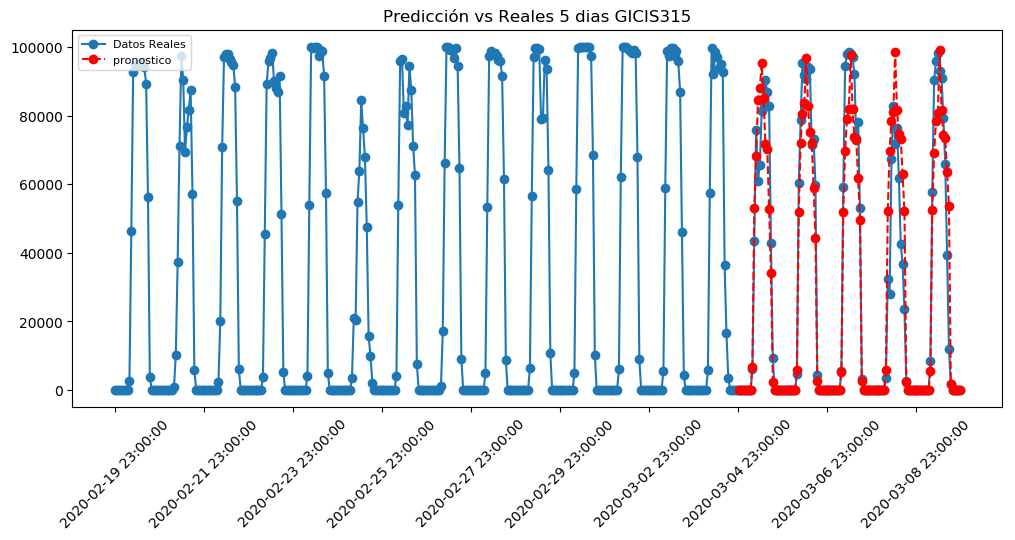

0    0.155785
dtype: float64


In [26]:
arange_dates = []
arange_no = []
arange = datos[columna][-1-19*24:].index
for i in range(0,len(arange),48):
    arange_dates.append(arange[i])
    arange_no.append(i)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(datos[columna][-1-19*24:], 'o-', label = 'Datos Reales')
plt.plot(pronostico, 'o--', label='pronostico',color ='r')
plt.title('Predicción vs Reales 5 dias '+columna)
plt.xticks(arange_no,arange_dates,rotation = 45)
plt.legend(loc='upper left', fontsize=8)
plt.show()

print(mape_promedio)
#print(fc)
#print(model)

In [27]:
Forecasts = pd.DataFrame(fcc).dropna().T

In [28]:
Forecasts.index = test.index
Forecasts.columns = test.columns
round(Forecasts,2)

,Hora 1,Hora 2,Hora 3,Hora 4,Hora 5,Hora 6,Hora 7,Hora 8,Hora 9,Hora 10,...,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19,Hora 20,Hora 21,Hora 22,Hora 23,Hora 24
2020-03-05,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,6758.84,53145.47,68061.52,...,71764.90,70225.47,52759.24,33990.38,2392.20,-0.0,-0.0,-0.0,-0.0,-0.0
2020-03-06,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,5800.00,51886.06,72130.66,...,75076.70,72050.58,58911.14,44395.59,2547.12,-0.0,-0.0,-0.0,-0.0,-0.0
2020-03-07,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,5266.31,51782.94,69622.27,...,73786.85,72836.29,61707.65,49467.73,2463.67,-0.0,-0.0,-0.0,-0.0,-0.0
2020-03-08,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,5819.14,52090.16,69596.40,...,74476.20,73174.54,62978.88,52082.11,2178.85,-0.0,-0.0,-0.0,-0.0,-0.0
2020-03-09,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,5485.22,52543.02,69179.04,...,74314.28,73320.16,63556.75,53563.83,1831.95,-0.0,-0.0,-0.0,-0.0,-0.0


In [29]:
test

,Hora 1,Hora 2,Hora 3,Hora 4,Hora 5,Hora 6,Hora 7,Hora 8,Hora 9,Hora 10,...,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19,Hora 20,Hora 21,Hora 22,Hora 23,Hora 24
2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5987.0,43461.0,75844.0,...,90367.0,86895.0,82839.0,42726.0,9186.0,0.0,0.0,0.0,0.0,0.0
2020-03-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4552.0,60195.0,78666.0,...,93489.0,71322.0,73012.0,59867.0,4257.0,0.0,0.0,0.0,0.0,0.0
2020-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5380.0,59301.0,94448.0,...,92149.0,73393.0,78253.0,53063.0,3049.0,0.0,0.0,0.0,0.0,0.0
2020-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3399.0,32430.0,27970.0,...,61664.0,42646.0,36716.0,23444.0,2638.0,0.0,0.0,0.0,0.0,0.0
2020-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8425.0,57663.0,90257.0,...,79152.0,65986.0,39226.0,12013.0,1679.0,0.0,0.0,0.0,0.0,0.0


In [30]:
new_mapes = np.abs((Forecasts - test) / test)
new_mapes[new_mapes == inf] = 0

In [31]:
new_mapes

,Hora 1,Hora 2,Hora 3,Hora 4,Hora 5,Hora 6,Hora 7,Hora 8,Hora 9,Hora 10,...,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19,Hora 20,Hora 21,Hora 22,Hora 23,Hora 24
2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.128919,0.222831,0.102612,...,0.205851,0.191835,0.363111,0.204457,0.739582,0.0,0.0,0.0,0.0,0.0
2020-03-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.274164,0.138034,0.083077,...,0.196946,0.010215,0.193131,0.258430,0.401662,0.0,0.0,0.0,0.0,0.0
2020-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021132,0.126778,0.262851,...,0.199266,0.007585,0.211434,0.067755,0.191975,0.0,0.0,0.0,0.0,0.0
2020-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.712016,0.606234,1.488252,...,0.207774,0.715860,0.715298,1.221554,0.174053,0.0,0.0,0.0,0.0,0.0
2020-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.348936,0.088791,0.233533,...,0.061119,0.111147,0.620271,3.458822,0.091093,0.0,0.0,0.0,0.0,0.0


In [32]:
new_mapes[[ 'Hora 8', 'Hora 9', 'Hora 10',
                           'Hora 11', 'Hora 12','Hora 13', 'Hora 14', 'Hora 15',
                          'Hora 16', 'Hora 17', 'Hora 18', 'Hora 19']]

,Hora 8,Hora 9,Hora 10,Hora 11,Hora 12,Hora 13,Hora 14,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19
2020-03-05,0.128919,0.222831,0.102612,0.386674,0.340660,0.170726,0.031130,0.205851,0.191835,0.363111,0.204457,0.739582
2020-03-06,0.274164,0.138034,0.083077,0.153874,0.087662,0.065228,0.120007,0.196946,0.010215,0.193131,0.258430,0.401662
2020-03-07,0.021132,0.126778,0.262851,0.191621,0.169136,0.002968,0.153743,0.199266,0.007585,0.211434,0.067755,0.191975
2020-03-08,0.712016,0.606234,1.488252,0.166551,0.022735,0.372865,0.069449,0.207774,0.715860,0.715298,1.221554,0.174053
2020-03-09,0.348936,0.088791,0.233533,0.182686,0.178754,0.065289,0.104042,0.061119,0.111147,0.620271,3.458822,0.091093


In [33]:
np.mean(new_mapes)

Hora 1     0.000000
Hora 2     0.000000
Hora 3     0.000000
Hora 4     0.000000
Hora 5     0.000000
Hora 6     0.000000
Hora 7     0.000000
Hora 8     0.297033
Hora 9     0.236534
Hora 10    0.434065
Hora 11    0.216281
Hora 12    0.159790
Hora 13    0.135415
Hora 14    0.095674
Hora 15    0.174191
Hora 16    0.207329
Hora 17    0.420649
Hora 18    1.042203
Hora 19    0.319673
Hora 20    0.000000
Hora 21    0.000000
Hora 22    0.000000
Hora 23    0.000000
Hora 24    0.000000
dtype: float64

In [34]:
mape_final = np.mean(np.mean(new_mapes[['Hora 8', 'Hora 9', 'Hora 10',
                           'Hora 11', 'Hora 12','Hora 13', 'Hora 14', 'Hora 15',
                          'Hora 16', 'Hora 17', 'Hora 18', 'Hora 19']]))

In [35]:
mape_final

0.3115697881071314